# 04_OHT_mooring

### Import packages

In [171]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units


import shapely
from shapely.geometry import Point
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# sys.path.append('../Libraries_functions/')
# from LIB_ASI_SIC_UniB import grab_ASI_SIC

# from LIB_geo_plot import *
# # from LIB_access_ERA5 import shift_bylons
# from LIB_PPdrift_NSIDC0116 import grab_icedrift_range

# path to own functions
sys.path.append('../../')
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import geofunc.vectors as vectors
import data_UniBremen.SIC as UNISIC
import data_OSISAF.icedrift_lr as osidrift
import timeseries.adjust as tseries
import timeseries.analyze as tanalyze
import geofunc.vectors as vectors


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import data

In [172]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

In [182]:
#===============================================================

# 2016-2017
# time_range = slice(datetime(2016, 12, 1), datetime(2017, 4, 30,23))

# 2017-2018
time_range = slice(datetime(2017, 12, 1), datetime(2018, 4, 30,23))

# 2018-2019
# time_range = slice(datetime(2018, 12, 1), datetime(2019, 2, 10,23))

#===============================================================

#=============
mooring = 'M2'
#=============

open_years = f'{time_range.start.year}_{time_range.stop.year}'

# calculate projected ESE current component
# u_val = np.cos(157.5 * np.pi/180)
# v_val = np.sin(157.5 * np.pi/180)

DS = xr.open_dataset(f'../data/polynya_size/daily_polynya_{time_range.stop.year}_sic30_v5.nc')
DS = DS.sel(time = time_range)
DS['length'] = (DS['l_per95'] - DS['l_per5'])
# DS['length'] = DS['l_max'] - DS['l_min']


# ocean velocity
#-----------------
ds = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc")
ds.close()
ds = ds.sel(time=time_range)
ds['se'] = vectors.comp_along_theta(ds.u, ds.v, 145*units('deg'))
ds['ne'] = vectors.comp_along_theta(ds.u, ds.v, (90+145)*units('deg'))
ds['speed'] = np.sqrt(ds.u**2+ ds.v**2)

# ocean temperature, sailinity
#-----------------------------
ds2 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_tempsalinity_{open_years}.nc")
ds2.close()
ds2 = ds2.sel(time=time_range)

ds2['dT'] = ds2.Ct - ds2.Tf

# sea ice velocity
#------------------
ds3 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_seaice_velocity_{open_years}.nc")
ds3.close()
ds3 = ds3.sel(depth=0, time=time_range)
ds3['se'] = vectors.comp_along_theta(ds3.u, ds3.v, 145*units('deg'))
ds3['speed'] = np.sqrt(ds3.u**2+ ds3.v**2)


ds6 = xr.open_dataset(f'../data/heat_flux/ohf_{time_range.stop.year}_v0.nc')
ds6 = ds6.sel(time=time_range)
ds6.close()


icespeed = np.sqrt(ds3.u**2 + ds3.v**2)

u_sfc = ds3.u.values
v_sfc = ds3.v.values

scf_angle = vectors.vector_angle(u_sfc, v_sfc)



# u_norm = u_sfc / icespeed
# v_norm = v_sfc / icespeed

# u_perp = - v_norm
# v_perp = u_norm

along_sfc = vectors.comp_along_theta(ds.u, ds.v, scf_angle)
perp_sfc  = vectors.comp_along_theta(ds.u, ds.v, scf_angle + 90*units('deg'))


# lat, lon = 70.5, -140 
# ds4 = grab_atm(time_range, lat = lat, lon = lon)
# ds4['speed'] = np.sqrt(ds4.u10**2+ ds4.v10**2)
# ds4['se'] = vectors.comp_along_theta(ds4.u10, ds4.v10, 135*units('deg'))
# wind_along_sfc = (ds4.u10 * u_norm) + (ds4.v10 * v_norm)
# wind_perp_sfc = (ds4.u10 * -v_norm) + (ds4.v10 * u_norm)


### Evaluate data gaps

In [183]:
#===================
retain_frac = 0.95
#===================

print(f'Ocean currents:')
for depth in ds.depth.values[::-1]:
    # finite fraction
    ffrac = np.sum(np.isfinite(ds.u.sel(depth=depth).values)) / len(ds.time)
    print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')

print(f'\nOcean temperatures:')
for depth in ds2.depth.values[::-1]:
    # finite fraction
    ffrac = np.sum(np.isfinite(ds2.Ct.sel(depth=depth).values)) / len(ds2.time)
    print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
    
print(f'\nSea ice velocity:')
# finite fraction
ffrac = np.sum(np.isfinite(ds3.u.values)) / len(ds3.time)
print(f'z = {0} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')

Ocean currents:
z = -51.0 [0.12] 
z = -55.0 [0.16] 
z = -59.0 [0.21] 
z = -63.0 [0.27] 
z = -67.0 [0.34] 
z = -75.0 [0.52] 
z = -79.0 [0.61] 
z = -83.0 [0.68] 
z = -87.0 [0.74] 
z = -91.0 [0.00] 
z = -95.0 [0.88] 
z = -99.0 [0.94] 
z = -103.0 [0.97] *
z = -107.0 [0.97] *
z = -111.0 [0.98] *
z = -115.0 [0.97] *
z = -119.0 [0.98] *
z = -123.0 [0.98] *
z = -127.0 [0.98] *
z = -131.0 [0.98] *
z = -135.0 [0.98] *
z = -139.0 [0.98] *
z = -143.0 [0.99] *
z = -147.0 [0.98] *
z = -155.0 [0.98] *
z = -159.0 [0.98] *
z = -163.0 [0.98] *

Ocean temperatures:
z = -40.0 [0.99] *
z = -57.0 [1.00] *
z = -74.0 [1.00] *
z = -91.0 [1.00] *
z = -109.0 [1.00] *
z = -126.0 [1.00] *
z = -143.0 [0.98] *
z = -162.0 [1.00] *

Sea ice velocity:
z = 0 [0.83] 


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_4107/362214240.py:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_4107/362214240.py:15: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_4107/362214240.py:20: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {0} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')


In [184]:
%matplotlib notebook

In [185]:
# cond = (ds.se.mean(dim='depth') > 0.1) 

cond = abs(ds2.dT.sel(depth = -16) - ds2.dT.sel(depth = -22)) < 0.1
cond2 = (ds2.dT.sel(depth = -16) < 0.1)
cond3 = (ds.se.mean(dim='depth') < 0.1)

np.sum(cond+cond2+cond3)/len(ds3.u)

KeyError: "not all values found in index 'depth'. Try setting the `method` keyword argument (example: method='nearest')."

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))


cond = (ds.se.mean(dim='depth') > 0.1) & (ds2.dT.sel(depth = -16) > 0.1)


for depth in ds2.depth.values[:-1]:
    ax.scatter(ds2.dT.sel(depth = -16)[cond], ds2.dT.sel(depth = depth)[cond], s=1)

In [186]:
for depth in ds2.depth.values:
    print(depth)

-162.0
-143.0
-126.0
-109.0
-91.0
-74.0
-57.0
-40.0


<IPython.core.display.Javascript object>


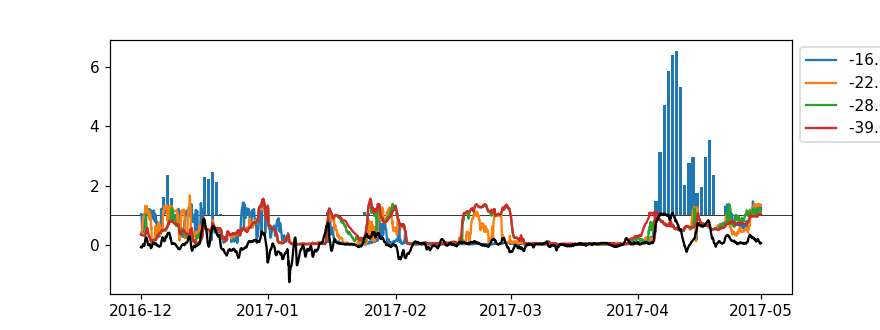

In [178]:
fig, ax = plt.subplots(figsize=(8,3))

# ax.axhline(30, c='k', lw=0.5)
# ax.plot(ds3.time, ds3.se + 30, c='k', label=f'ice se')

yy = 1
ax.axhline(yy, c='k', lw=0.5)
ax.bar(DS.time, DS.extent/1000, align='edge', bottom = yy)

# for depth in ds.depth.values[::-1][:10]:
#     ax.plot(ds.time, ds.se.sel(depth = depth)-ds.se.sel(depth = -7.3), label=f'{depth} m')
    
for depth in ds2.depth.values[::-1]:
    ax.plot(ds2.time, ds2.dT.sel(depth = depth), label=f'{depth} m')
    
    
# ax.plot(ds.time, ds3.se-ds.se.sel(depth = -7.3), c='gray')
# ax.plot(ds.time, ds3.se, c='k')

# plt.pcolormesh(ds2.time, ds2.depth[:-1], ds2.sig0.diff('depth') / ds2.depth.diff('depth'), vmin=-0.25, vmax=0.25, cmap=cmocean.cm.balance)
    
ax.plot(ds.time, ds.se.mean(dim='depth'), c='k')


plt.legend(bbox_to_anchor=(1,1))

# plt.ylim(-2,2)
# plt.ylabel('sig0 (kg/m3)')
# plt.title(mooring)



# Interpolate / Extrapolate velocities

In [57]:
og_z

array([-35.3, -33.3, -31.3, -29.3, -25.3, -23.3, -21.3, -19.3, -17.3,
       -15.3, -13.3, -11.3,  -9.3,  -7.3,  -5.3,  -3.3])

In [179]:
def time_interp(time, data, max_interp):
    
    # time - interp
    data_interp, dt_interp = tseries.linear_interpolate(og_times, og_times, data, max_dt = max_interp)

    return data_interp


def interp_z(z_vals, og_times, data_grid, og_data, og_z, need_interp_z):
    
    d_grid = np.copy(data_grid)
    
    for zz in need_interp_z:
        
        print(zz)

        # find index
        zi = np.where(z_vals == zz)[0][0]

        # find nan times
        iter_tt = np.arange(len(og_times))[np.isnan(d_grid[zi,:])]

        for tt in iter_tt:

            non_nan_zs = og_z[np.isfinite(og_data[:,tt])]
            
            # identify closest non-nan depths above and below
#             non_nan_zs = z_vals[np.isfinite(d_grid[:,tt])]

            if len(non_nan_zs) > 0:
                
                if np.sum(non_nan_zs < zz) > 0 and np.sum(non_nan_zs > zz) > 0:

                    z_abv = non_nan_zs[non_nan_zs > zz].min()
                    z_blw = non_nan_zs[non_nan_zs < zz].max()

                    # grab their indices
                    zi_abv = np.where(og_z == z_abv)[0][0]
                    zi_blw = np.where(og_z == z_blw)[0][0]

                    # interp the values across gap
                    duT = og_data[zi_abv, tt]-og_data[zi_blw, tt]
                    dzT = z_abv-z_blw

                    dzt = zz-z_blw

                    d_grid[zi, tt] = og_data[zi_blw, tt] + dzt*(duT/dzT)

    return d_grid
        
    
    
    
def handle_sfc_nans(og_times, data_grid, method = 'extend'):
    
    zz = 0 
    zi0 = np.where(z_vals == zz)[0][0]

    # find nan times
    iter_tt = np.arange(len(og_times))[np.isnan(data_grid[zi0,:])]
    
    for tt in iter_tt:
        
        # identify closest non-nan depths below
        non_nan_zs = z_vals[np.isfinite(data_grid[:,tt])]
        
        # identify closest non-nan depth below
        z_blw = non_nan_zs[non_nan_zs < zz].max()
        zi_blw = np.where(z_vals == z_blw)[0][0]
        
        if str(method) == 'extend':
            # replace surface layer with value at given layer
            data_grid[zi0,tt] = data_grid[zi_blw, tt]
            
        elif str(method) == 'extrapolate':
            # identify 2nd closest non-nan depth below
            z2_blw = non_nan_zs[non_nan_zs < z_blw].max()
            z2i_blw = np.where(z_vals == z2_blw)[0][0]

            # change across defined values
            dz_d = z_blw - z2_blw
            dv_d = data_grid[zi_blw, tt] - data_grid[z2i_blw, tt]
            
            # change across desired range
            dz_u = zz - z2_blw

            # extraploate to final point
            dv_u = dz_u * (dv_d/dz_d)
            
            data_grid[zi0,tt] = dv_u + data_grid[z2i_blw, tt]
            
    return data_grid
            
    
    
def identify_matching_layers(og_data, z_vals, addressed_z):

    # identify exact matching z and those that need interp
    exact_z = []
    need_interp_z = []
    for zi, zz in enumerate(z_vals):
        if zz not in addressed_z:

            if zz in og_z:
                num_nonnan = np.sum(np.isfinite(og_data.sel(depth=zz).values))

                if num_nonnan > 0:
                    exact_z.append(zz)
                else:
                    need_interp_z.append(zz)
            else:
                need_interp_z.append(zz)
                
    return exact_z, need_interp_z


def copy_matching_layers(data_grid, og_data, z_vals, exact_z, max_interp):
    

    # sub in existing ocean currents if direct match
    for zz in exact_z:

        # find index
        zi = np.where(z_vals == zz)[0][0]

        # find og vals
        og_val = og_data.sel(depth=zz).values

        # time-interpolate ice velocities to remove small gaps
        data_grid[zi, :] = time_interp(og_times, og_val, max_interp)

        print(f'z = {zz}: * matching o')
        
    return data_grid
#         addressed_z.append(zz)

#     for zz in need_interp_z:
#         print(f'z = {zz}: -needs interp:')




def handle_bottom_nans(data_grid, og_data, z_vals, lowest_z, og_times, og_z, max_interp, method = 'extend'):
    
    # (2a) extend lowest velocities across bottom
    #--------------------------------------------
    
    # indices to address
#     zi_s = np.arange(len(z_vals))[z_vals < lowest_z]
    
    if str(method) == 'extend':

        # grab lowest velocity
        data_val = np.array([])
        lowest_zs_used = np.array([])
        
        for time in og_times:
            
            og_crop = og_data.sel(time = time)
            lowest_z = og_z[np.isfinite(og_crop.values)].min()
            lowest_zs_used = np.append(lowest_zs_used, lowest_z)
            data_val = np.append(data_val, og_data.sel(time = time).sel(depth=lowest_z).values  )
            
#         data_val = og_data.sel(depth=lowest_z).values

        # time-interpolate ice velocities to remove small gaps
        data_interp = time_interp(og_data, data_val, max_interp)

        for tt in range(len(og_times)):
            
            zi_max = np.where(z_vals < lowest_zs_used[tt])[0][-1]
            data_grid[:zi_max+1, tt] = data_interp[tt]
            
#             zi_s = [z_vals[z_vals < lowest_z].min() for lowest_z in lowest_zs_used[tt]]

#             for zi in zi_s:

#                 zz = z_vals[zi]

#                 print(f'z = {zz} : {method}')

#                 data_grid[zi, :] = data_interp

    
    elif str(method) == 'extrapolate':
        
        lowest_zs_used = []
        
        for zi in zi_s:

            zz = z_vals[zi]
            
            print(f'z = {zz} : {method}')
            
            for tt in np.arange(len(og_times)):

                # identify closest non-nan depths above
                non_nan_zs = z_vals[np.isfinite(data_grid[:,tt])]

                z_abv = non_nan_zs[non_nan_zs > zz].min()
                zi_abv = np.where(z_vals == z_abv)[0][0]

                # identify 2nd closest non-nan depth above
                z2_abv = non_nan_zs[non_nan_zs > z_abv].min()
                z2i_abv = np.where(z_vals == z2_abv)[0][0]

                # change across defined values
                dz_d = z_abv - z2_abv
                dv_d = data_grid[zi_abv, tt] - data_grid[z2i_abv, tt]

                # change across desired range
                dz_u = zz - z2_abv

                # extraploate to final point
                dv_u = dz_u * (dv_d/dz_d)

                data_grid[zi,tt] = dv_u + data_grid[z2i_abv, tt]

    
    return data_grid, lowest_zs_used

    

In [ ]:
# J m-2 s-1

# Cp * dt * sig0 * u 



# A = 10000*40

# J s-1

# Cp * dt * sig0 * u * A


In [192]:





#=========================
# og data
dss = ds2
og_data = dss['dT'] * (1000+dss['sig0'])

# og data
# dss = ds
# og_data = dss['se']
# og_data = -dss['u']



# specify surface conditions
og_sfc =  np.full(len(dss.time), np.nan)
sfc_method = 'extend'

# specify bottom conditions
og_bot =  np.full(len(dss.time), np.nan)
bottom_method = 'extend'

# max time gap allowed in time interp
max_interp = 6 * units('hour')

# new z vals
# z_vals = np.linspace(-40,0,21)
z_vals = np.arange(-180,1,10)
#=========================

# time-interpolate surface velocities to remove small gaps
# sfc_interp = time_interp(og_times, og_sfc, max_interp)
# data_grid[zi, :] = sfc_interp


# og grids
og_times = pd.to_datetime(dss.time)
og_z = np.copy(dss.depth.values)

# start empty grid
data_grid = np.full((len(z_vals), len(dss.time)), np.nan)

# add in top and bottom values as specified
data_grid[-1,:] = og_sfc
data_grid[0,:] = og_bot

addressed_z = []



# Directly copying matching layers
#======================================================
print(f'\nMiddle layers handling : copy matching layers')
exact_z, need_interp_z = identify_matching_layers(og_data, z_vals, addressed_z)
data_grid = copy_matching_layers(data_grid, og_data, z_vals, exact_z, max_interp)


# Interp where data exist
#======================================================
# first just for missing layers
data_grid = interp_z(z_vals, og_times, data_grid, og_data, og_z,  need_interp_z)

# Handling the bottom
#======================================================
# find lowest velocities
print(f'\nBottom boundary handling :')
data_grid, lowest_zs_used = handle_bottom_nans(data_grid, og_data, z_vals, lowest_z, 
                               og_times,og_z, max_interp, method = bottom_method)




# Handling the surface
#======================================================
# find index of surface
zi = np.where(z_vals == 0)[0][0]
data_grid = handle_sfc_nans(og_times, data_grid, method = sfc_method)

print(f'\nTop boundary handling :')
print(f'z = {0}: * matching surface')
addressed_z.append(z_vals[zi])


# (5) Handling missing data in surface-most layer
#======================================================
# extend nearest-to-sfc. values to the surface
# find index of surface-most layer
# data_grid = handle_sfc_nans(og_times, data_grid, method = sfc_method)


# (6) Handling missing data in middle layers
#======================================================    
# then once more across all layers to fill gaps
# fill from newly-filled grid
data_grid = interp_z(z_vals, og_times, data_grid, data_grid, z_vals,  z_vals[z_vals!=0])



Middle layers handling : copy matching layers
z = -40: * matching o
-180
-170
-160
-150
-140
-130
-120
-110
-100
-90
-80
-70
-60
-50
-30
-20
-10
0

Bottom boundary handling :

Top boundary handling :
z = 0: * matching surface
-180
-170
-160
-150
-140
-130
-120
-110
-100
-90
-80
-70
-60
-50
-40
-30
-20
-10


<IPython.core.display.Javascript object>


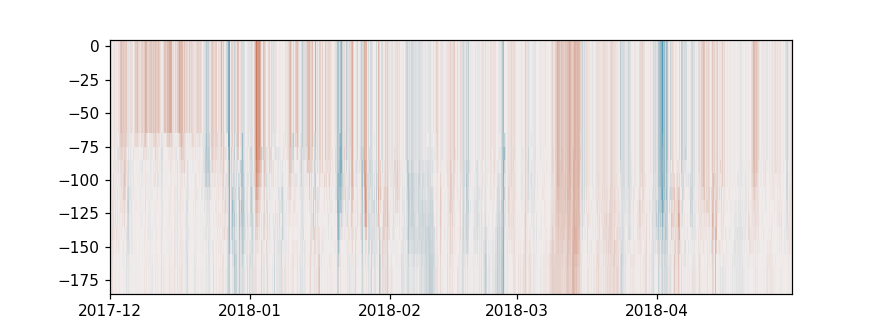

<IPython.core.display.Javascript object>


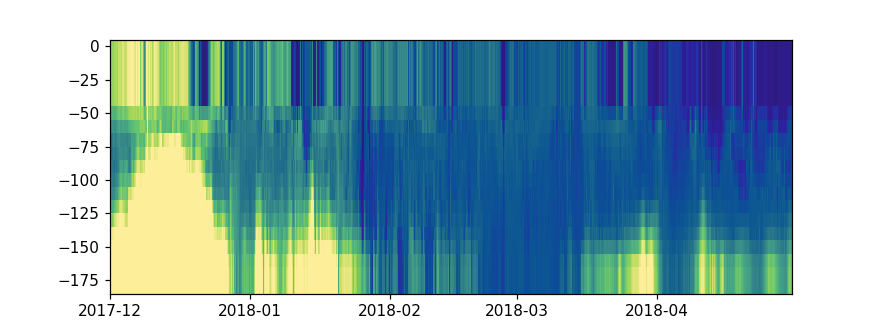

In [193]:
fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, data_grid2, cmap=cmocean.cm.balance, vmin=-1, vmax=1)

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, data_grid, cmap=cmocean.cm.haline, vmin=0, vmax=1500)


In [157]:
cst['Cp_o'] * units('delta_degC kg/m3')

<Quantity(3850.0, 'joule / meter ** 3')>

In [195]:
u_grid = data_grid2 * units('m/s')
ts_grid = data_grid * units('delta_degC kg/m3')

hf = cst['Cp_o'] * u_grid * ts_grid

In [196]:
# data_grid2 = data_grid

<IPython.core.display.Javascript object>


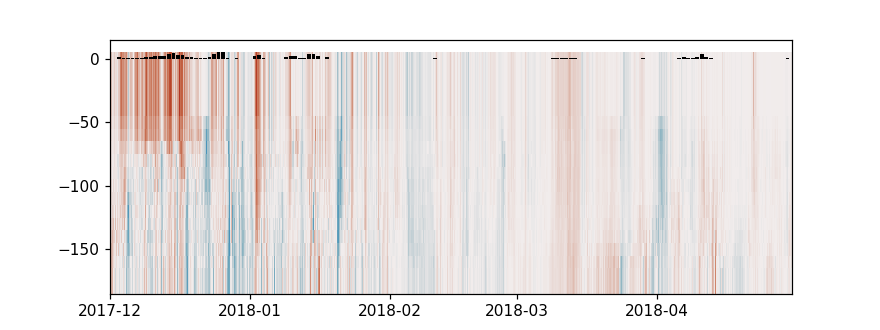

<BarContainer object of 151 artists>

In [199]:

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, hf, cmap=cmocean.cm.balance, vmin=-2000000, vmax=2000000)
plt.bar(DS.time, DS.extent/1000, color='k')

In [229]:
z_vals[-10:-5]

array([-90, -80, -70, -60, -50])

In [240]:
z_vals[-18:-13]

array([-170, -160, -150, -140, -130])

<IPython.core.display.Javascript object>


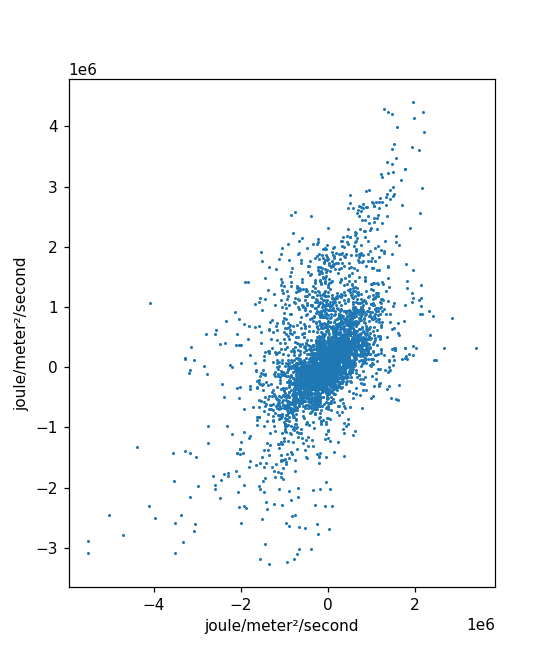

In [241]:
fig, ax = plt.subplots(figsize=(5,6))

plt.scatter(np.sum(hf[-18:-13, :], axis=0), np.sum(hf[-10:-5,:], axis=0), s=1)

<IPython.core.display.Javascript object>


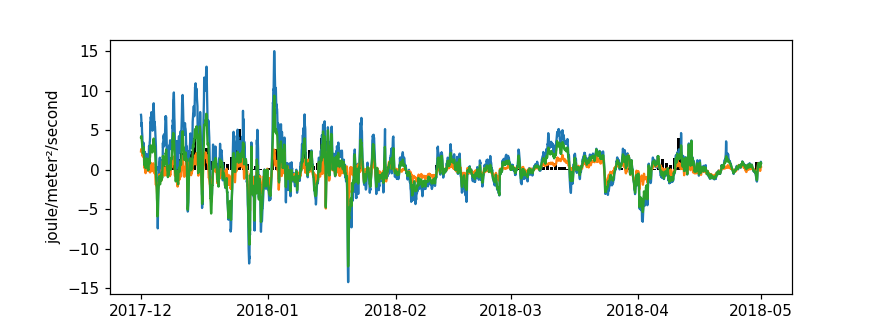

In [220]:
fig, ax = plt.subplots(figsize=(8,3))
plt.bar(DS.time, DS.extent.values/1000, color='k')
plt.plot( dss.time, np.sum(hf, axis=0)/1000000)
plt.plot( dss.time, np.sum(hf[:-13,:], axis=0)/1000000)
plt.plot( dss.time, np.sum(hf[:-5,:], axis=0)/1000000)

<IPython.core.display.Javascript object>


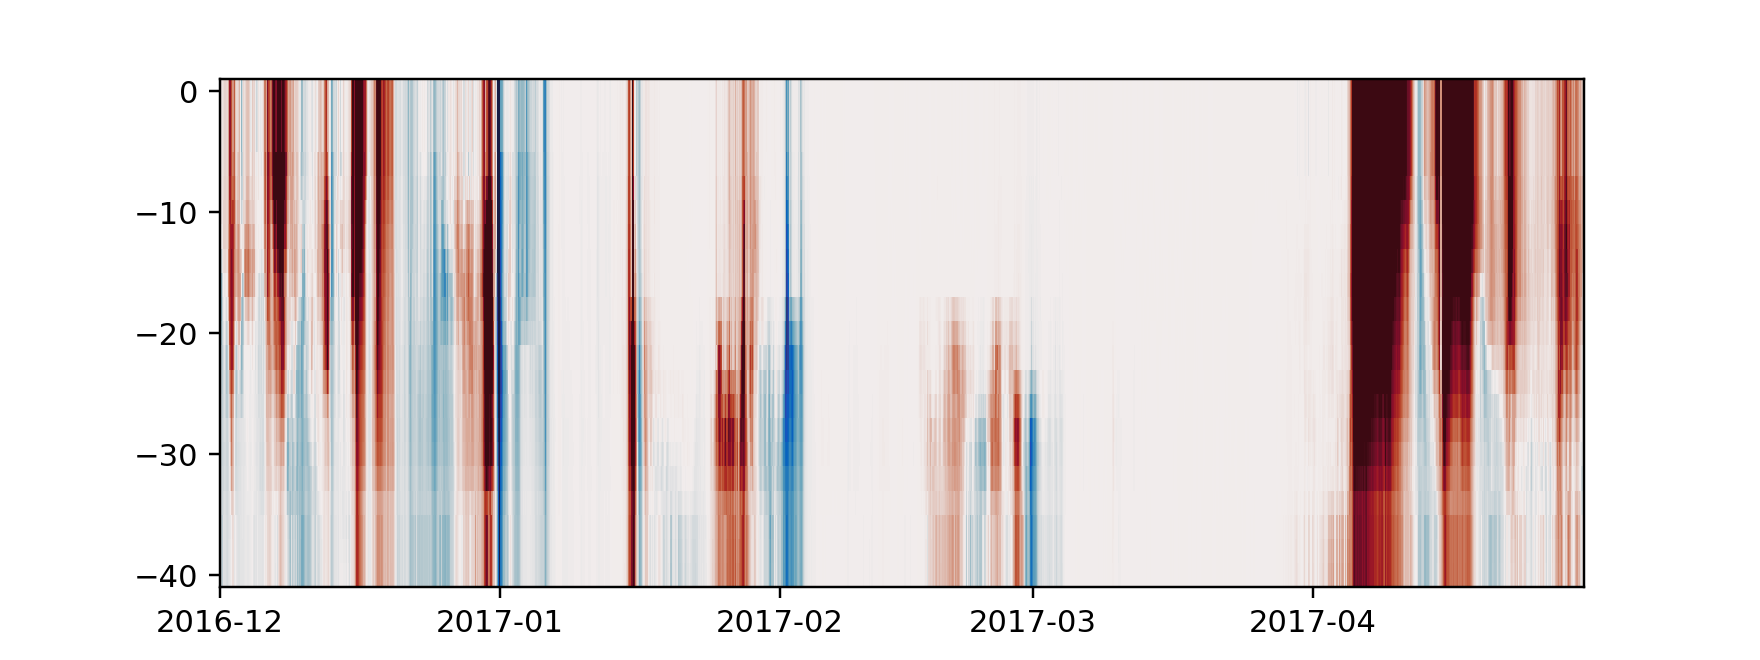

In [136]:

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, hf, cmap=cmocean.cm.balance, vmin=-2000000, vmax=2000000)
# plt.contour( dss.time, z_vals, ts_grid, levels=[500], colors=['gold'])


<IPython.core.display.Javascript object>


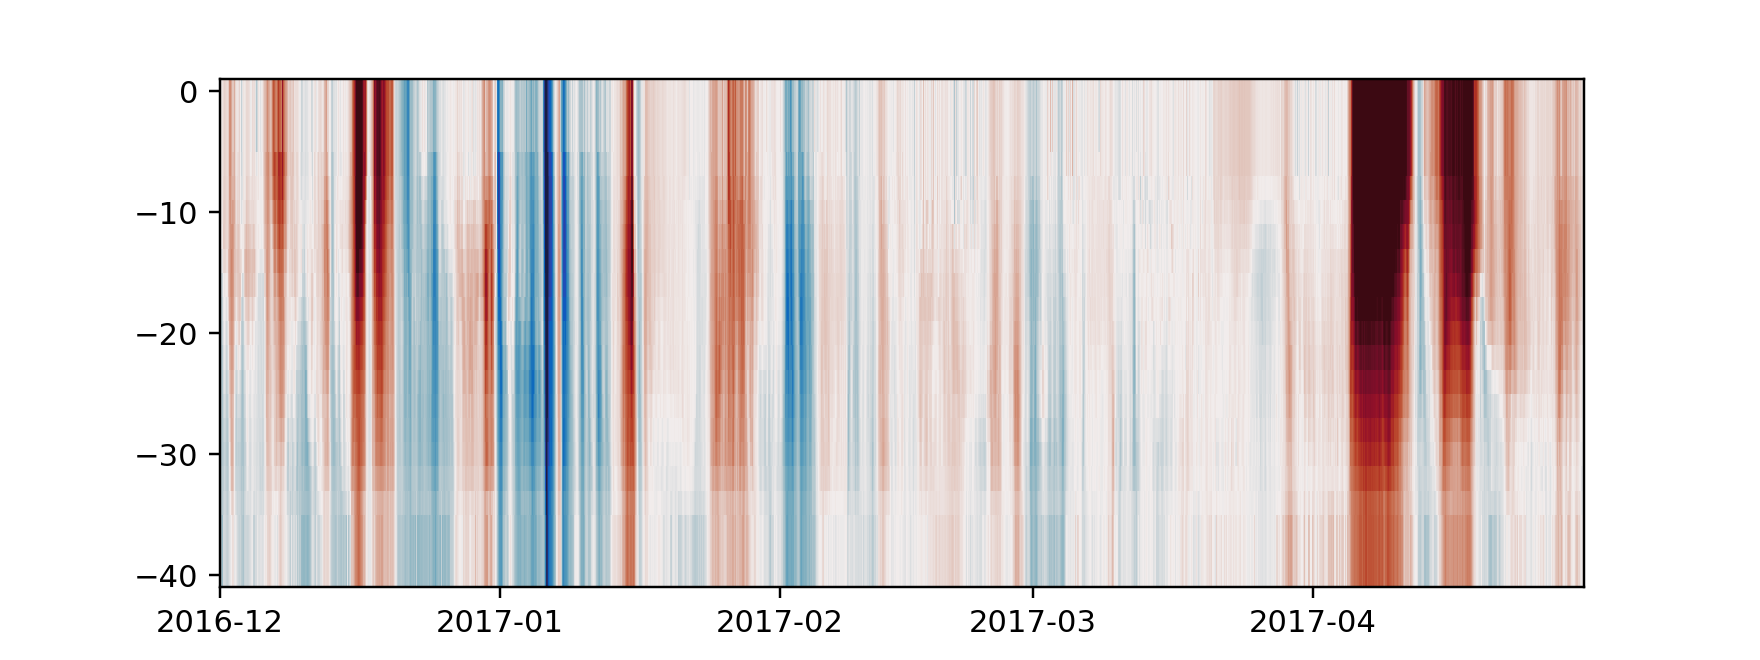

In [130]:

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, data_grid2, cmap=cmocean.cm.balance, vmin=-1, vmax=1)


<IPython.core.display.Javascript object>


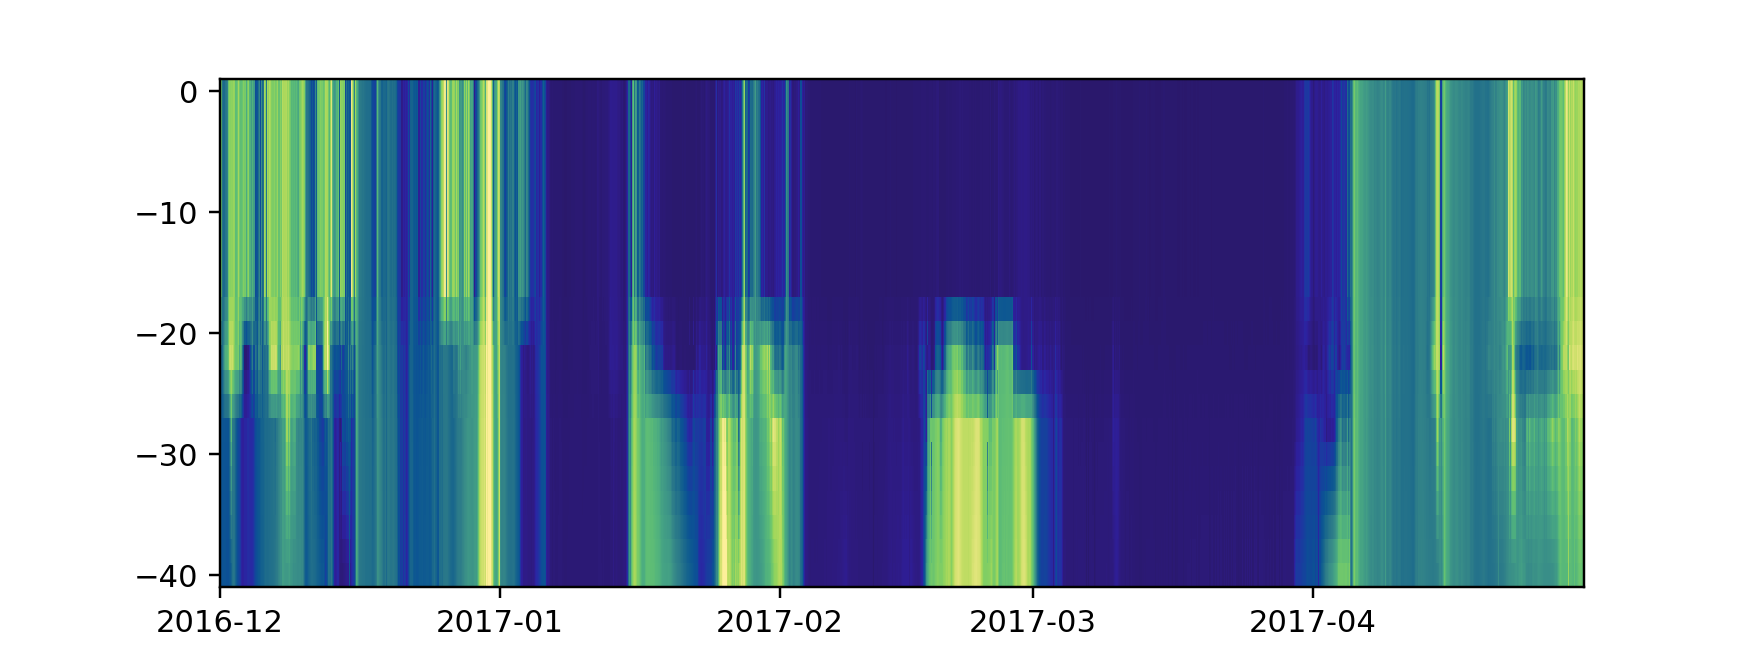

In [138]:

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, data_grid, cmap=cmocean.cm.haline, vmin=0, vmax=1500)


In [141]:
DS

<xarray.Dataset>
Dimensions:               (time: 151)
Coordinates:
  * time                  (time) datetime64[ns] 2016-12-01 ... 2017-04-30
Data variables: (12/25)
    N                     (time) float64 ...
    extent                (time) float64 nan nan nan nan nan ... nan nan nan nan
    l_min                 (time) float64 ...
    l_max                 (time) float64 ...
    l_mean                (time) float64 ...
    l_per5                (time) float64 ...
    ...                    ...
    ice_extent            (time) float64 ...
    ocean_extent          (time) float64 ...
    other_polynya_extent  (time) float64 ...
    polynya_extent        (time) float64 ...
    miss_flag             (time) bool ...
    length                (time) float64 nan nan nan nan nan ... nan nan nan nan

In [151]:
z_vals[10:]

array([-20., -18., -16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.])

<IPython.core.display.Javascript object>


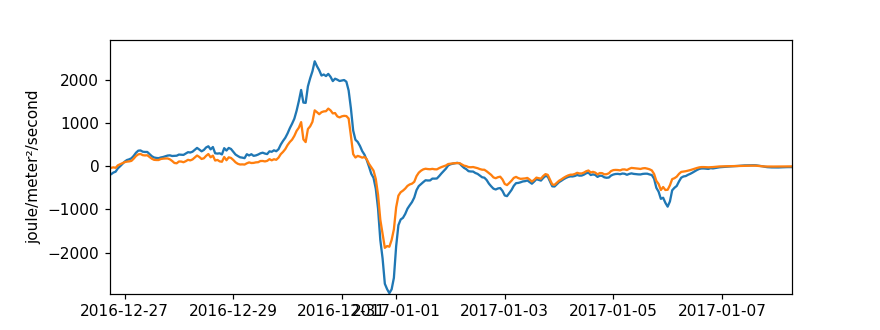

<BarContainer object of 151 artists>

In [181]:
fig, ax = plt.subplots(figsize=(8,3))
plt.plot( dss.time, np.sum(hf, axis=0)/20000)
plt.plot( dss.time, np.sum(hf[10:,:], axis=0)/20000)
plt.bar(DS.time, DS.extent.values, align='edge', color='k')



In [86]:
lowest_zs_used

array([-35.3, -35.3, -35.3, ..., -33.3, -33.3, -33.3])

<IPython.core.display.Javascript object>


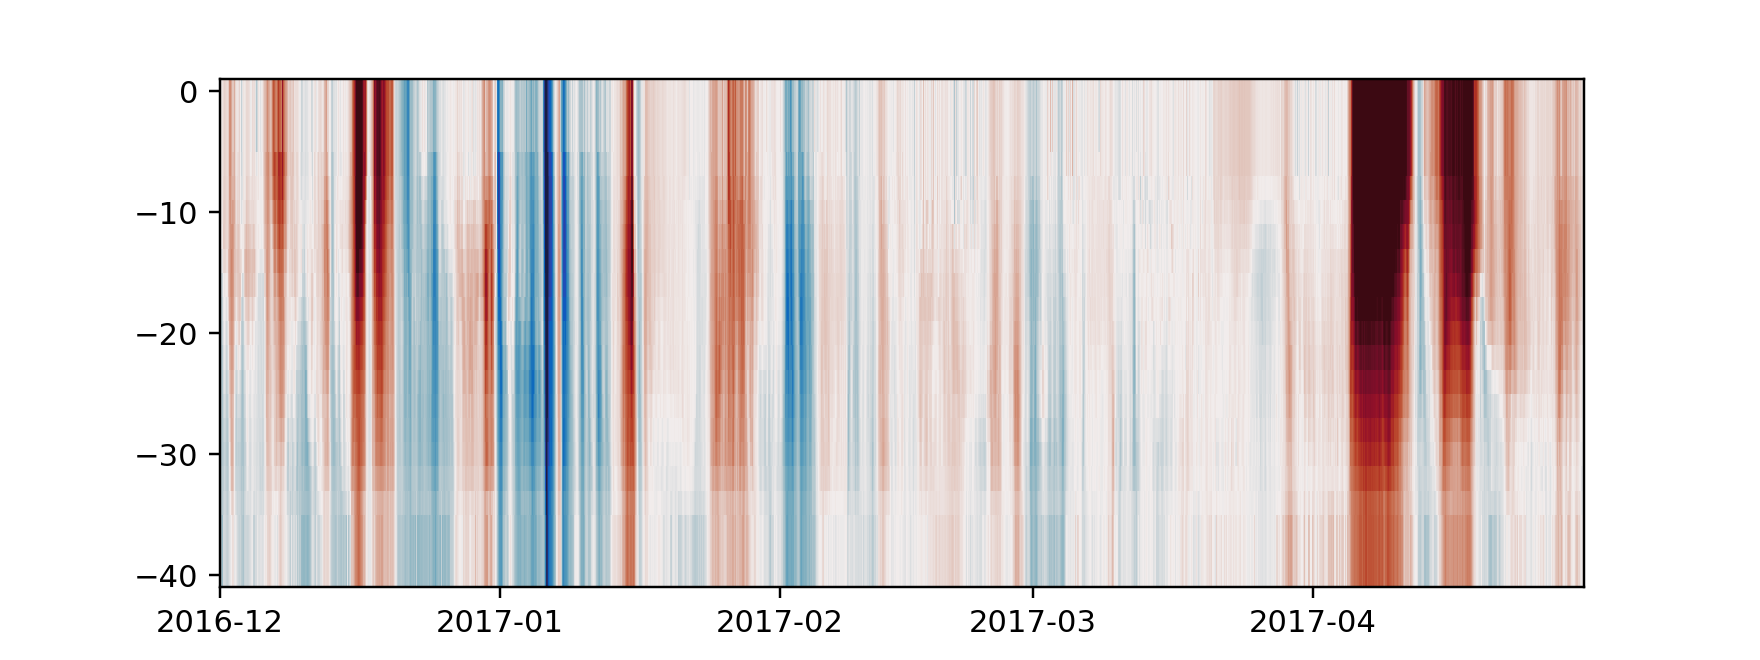

In [103]:

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, data_grid, cmap=cmocean.cm.balance, vmin=-1, vmax=1)

# plt.pcolormesh( dss.time, z_vals, data_grid, cmap=cmocean.cm.haline, vmin=0, vmax=1200)

<IPython.core.display.Javascript object>


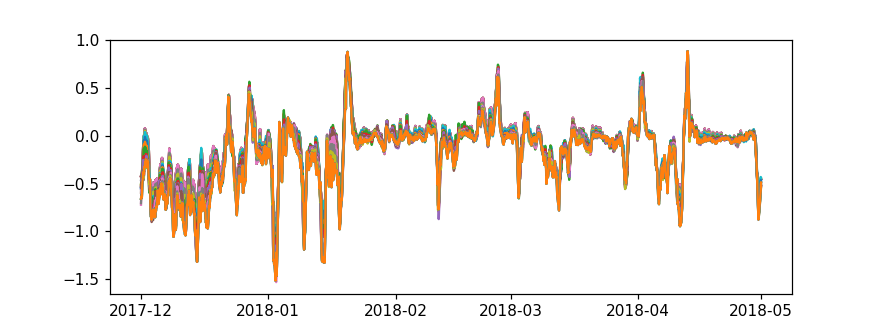

In [841]:
fig, ax = plt.subplots(figsize=(8,3))

plt.plot(dss.time,np.mean(data_grid, axis=0))

for zi, zz in enumerate(z_vals):

    plt.plot(dss.time,  data_grid[zi, :])

<IPython.core.display.Javascript object>


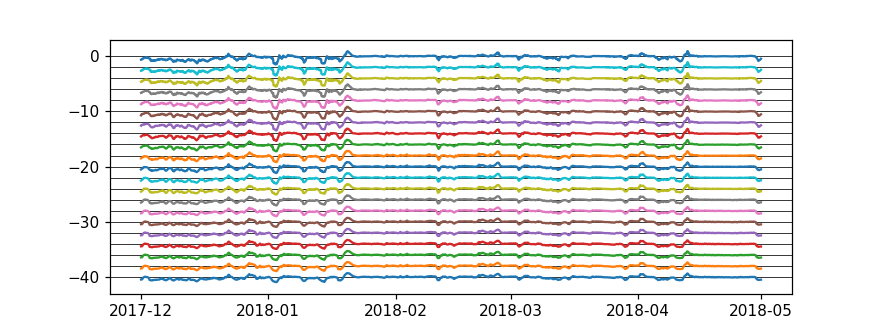

In [843]:
fig, ax = plt.subplots(figsize=(8,3))
# plt.pcolormesh(ds.time, z_vals, u_grid)

for zi, zz in enumerate(z_vals):
    
    plt.axhline(zz, c='k', lw=0.5)
    plt.plot(dss.time,  zz+ data_grid[zi, :])


## Calculate Integrated Ocean Heat Content

Use trapezoidal rule to estimate integrate ocean heat content
OHC = $\sum{\frac{1}{2} [f(x_i) + f(x_{i+1})}] \Delta x$

$\mathrm{f(z) = C_{p} \;\rho_{o}(z)\; (\Theta(z) - \Theta_{freezing}(z))}$

In [2]:
OHC = np.array([])

Z = np.append(np.array([0]), ds2.depth.values[::-1])

for ii in range(len(Z[:-1])):
    
    print(ii)
    
    za = Z[ii] * units('m')
    zb = Z[ii+1] * units('m')
    
    dz = za - zb
    
    print(f'za = {za}; zb = {zb}; dz = {dz}')
    
    # define upper
    if ii == 0:
        rho_a = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
        dCTa = np.zeros(len(ds2.Ct.sel(depth = zb))) * units('delta_degC')

    else:
        rho_a = (ds2.sel(depth = za).sig0 + 1000).values * units('kg/m^3')
        dCTa = (ds2.Ct - ds2.Tf).sel(depth = za).values * units('delta_degC')
        
    # grab lower
    rho_b = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
    dCTb = (ds2.Ct - ds2.Tf).sel(depth = zb).values * units('delta_degC')
    
    layer_hc = 0.5 * dz

    f_za = cst['Cp_o'] * rho_a * dCTa
    f_zb = cst['Cp_o'] * rho_b * dCTb
    
    OHC = np.append(OHC, 0.5 * (f_za + f_zb) * dz)
    
    
OHC = np.reshape(OHC, (len(Z[:-1]), len(ds2.time), ))

NameError: name 'ds2' is not defined

## Calculate Integrated Ocean Heat Transport

Use trapezoidal rule to estimate integrate ocean heat content
OHC = $\sum{\frac{1}{2} [f(x_i) + f(x_{i+1})}] \Delta x$

$\mathrm{f(z) = C_{p} \;\rho_{o}(z)\; U_{\perp}(z)\; (\Theta(z) - \Theta_{freezing}(z))}$

In [30]:
OHT = np.array([])

Z = np.append(np.array([0]), ds2.depth.values[::-1])

for ii in range(len(Z[:-1])):
    
    print(ii)
    
    za = Z[ii] * units('m')
    zb = Z[ii+1] * units('m')
    
    dz = za - zb
    
    print(f'za = {za}; zb = {zb}; dz = {dz}')
    
    # define upper
    if ii == 0:
        rho_a = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
        dCTa = np.zeros(len(ds2.Ct.sel(depth = zb))) * units('delta_degC')

    else:
        rho_a = (ds2.sel(depth = za).sig0 + 1000).values * units('kg/m^3')
        dCTa = (ds2.Ct - ds2.Tf).sel(depth = za).values * units('delta_degC')
        
    # grab lower
    rho_b = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
    dCTb = (ds2.Ct - ds2.Tf).sel(depth = zb).values * units('delta_degC')
    
    layer_hc = 0.5 * dz

    f_za = cst['Cp_o'] * rho_a * dCTa
    f_zb = cst['Cp_o'] * rho_b * dCTb
    
    OHT = np.append(OHT, 0.5 * (f_za + f_zb) * dz)
    
    
OHT = np.reshape(OHT, (len(Z[:-1]), len(ds2.time), ))

0
za = 0.0 meter; zb = -16.0 meter; dz = 16.0 meter
1
za = -16.0 meter; zb = -22.0 meter; dz = 6.0 meter
2
za = -22.0 meter; zb = -28.0 meter; dz = 6.0 meter
3
za = -28.0 meter; zb = -36.0 meter; dz = 8.0 meter


In [38]:
OHT

Magnitude,[[26917566.995612476 27026948.464659218 27100261.584444612 ... 9843665.916484108 9823871.909135275 9683817.518322984] [19120542.67190513 18846905.463436056 18825402.9094734 ... 7408086.214058454 7385164.644822245 7284001.150824107] [16306041.372136239 15895511.716126543 15798739.682484286 ... 7416593.854702475 7420676.2940026475 7316697.213718663] [19783978.365800038 19467046.33491791 19276352.226737894 ... 9957654.16977061 nan 9873030.862214431]]
Units,joule/meter2


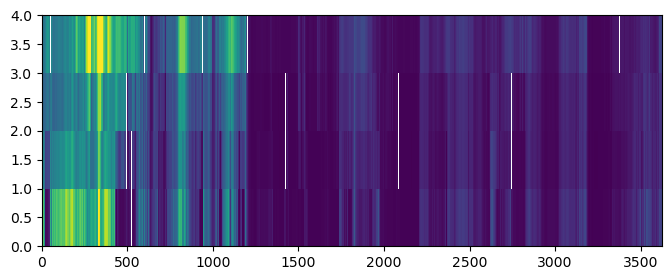

In [40]:
fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh(OHT, vmin=0, vmax=50000000)